In [146]:
from sdv.demo import load_timeseries_demo
import pandas as pd

In [147]:
data = pd.read_csv('./AAPL Historical Data.csv')

In [148]:
data.head()

,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17


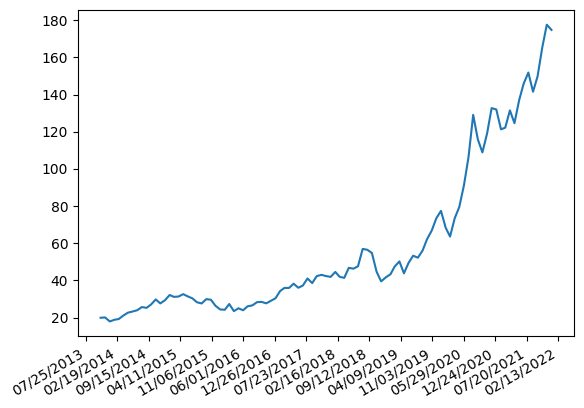

In [149]:
import matplotlib as plt
dates = list(data['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
y = list(data['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [159]:
from sdv.timeseries import PAR


In [160]:
model = PAR(
  )

In [161]:
model.fit(data)

In [182]:
data_new = model.sample(2)

ValueError: No objects to concatenate

In [179]:
data_new = pd.DataFrame(data_new)

In [180]:
data_new['Date'] =pd.to_datetime(data_new.Date)
data_new = data_new.sort_values(by='Date')
data_new.to_csv('new.csv')

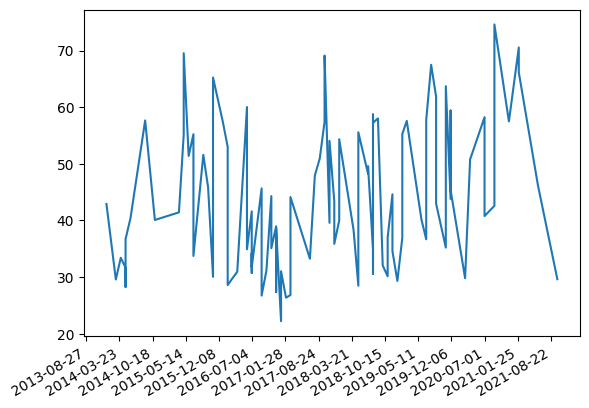

In [181]:
import matplotlib as plt
data_new = pd.read_csv('new.csv')
dates = list(data_new['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data_new['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()